In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('fivethirtyeight')
%matplotlib inline

In [69]:
confirmcase_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
recoveries_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")


In [70]:
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,0,0,1,1,1,2,4,4,4,4
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,2,2,2,4,5,5,6,8,10,10
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,11,15,17,17,19,21,25,26,29,31
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,0,0,1,1,1,1,3,3,3,6
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [71]:
recoveries_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1,1,1,1,1,2,2,2,2,2
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,0,2,2,2,10,17,17,31,31,33
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,32,32,65,65,24,65,29,29,31,31
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
cols = confirmcase_df.keys()

In [73]:
confirmed = confirmcase_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [74]:
dates = confirmed.keys()
world_cases = []
total_deaths = []
mortality_rate = []
recovery_rate = []
total_recovered = []
total_active = []
china_cases = []
italy_cases = []
us_cases = []
spain_cases = []
india_cases = []
for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    #calculate rates
    
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)
    
    #country wise datas
    china_cases.append(confirmcase_df[confirmcase_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmcase_df[confirmcase_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmcase_df[confirmcase_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmcase_df[confirmcase_df['Country/Region']=='Spain'][i].sum())
    india_cases.append(confirmcase_df[confirmcase_df['Country/Region']=='India'][i].sum())

In [75]:
def daily_increase(data):
    d = []
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d

world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
india_daily_increase = daily_increase(india_cases)

In [76]:
day_since_first_case = np.array([i for i in range(len(dates))]).reshape(-1, 1)

world_cases = np.array(world_cases).reshape(-1 , 1)
total_deaths = np.array(total_deaths).reshape(-1 , 1)
total_recovered = np.array(total_recovered).reshape(-1 , 1)

In [77]:
days_in_future = 20
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1 , 1)
adjusted_dates = future_forecast[:-20]

In [78]:
start = '22/1/2020'
start_date = datetime.datetime.strptime(start, '%d/%m/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y'))
    

In [79]:
X_train_confirmed , X_test_confirmed , y_train_confirmed , y_test_confirmed = train_test_split(day_since_first_case , world_cases , test_size=0.2 , shuffle = False)

In [80]:
# use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5, 6, 7]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [81]:
svm_confirmed = SVR(shrinking = True , kernel = 'poly' , gamma = 0.01 , epsilon = 1 , degree = 8 , C=0.1)
svm_confirmed.fit(X_train_confirmed,y_train_confirmed)
svm_predict = svm_confirmed.predict(future_forecast)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error: 13185.854230268193
Mean Squared Error: 203002659.44667488


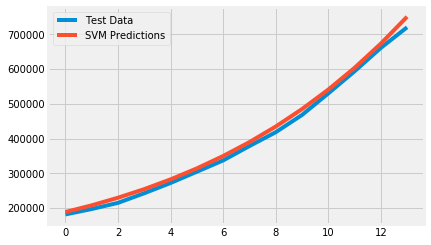

In [82]:
# testing against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed) 
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('Mean Absolute Error:',mean_absolute_error(svm_test_pred,y_test_confirmed))
print('Mean Squared Error:',mean_squared_error(svm_test_pred,y_test_confirmed))

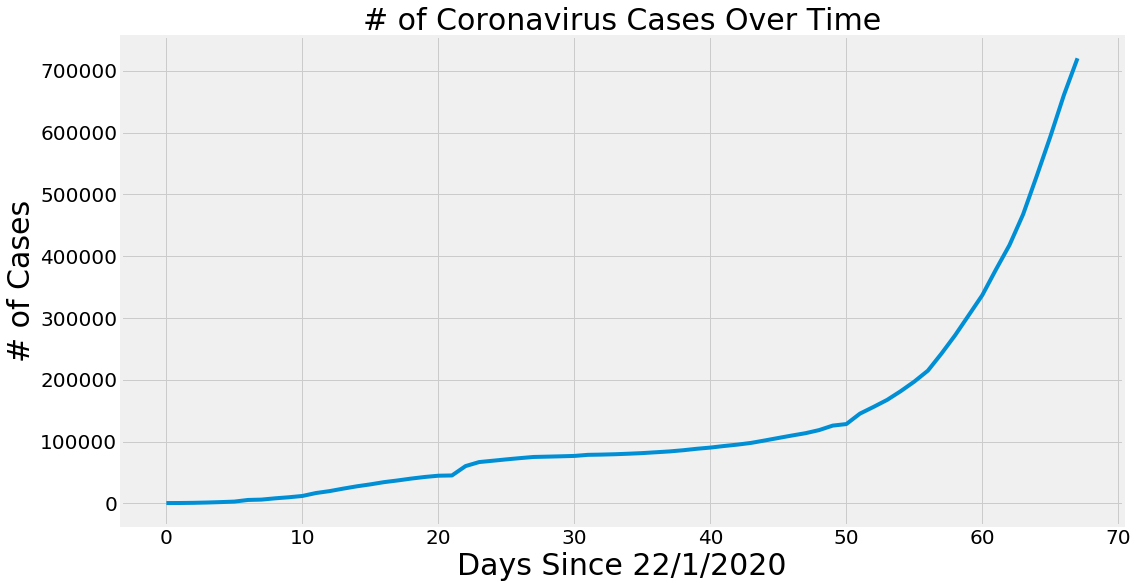

In [83]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

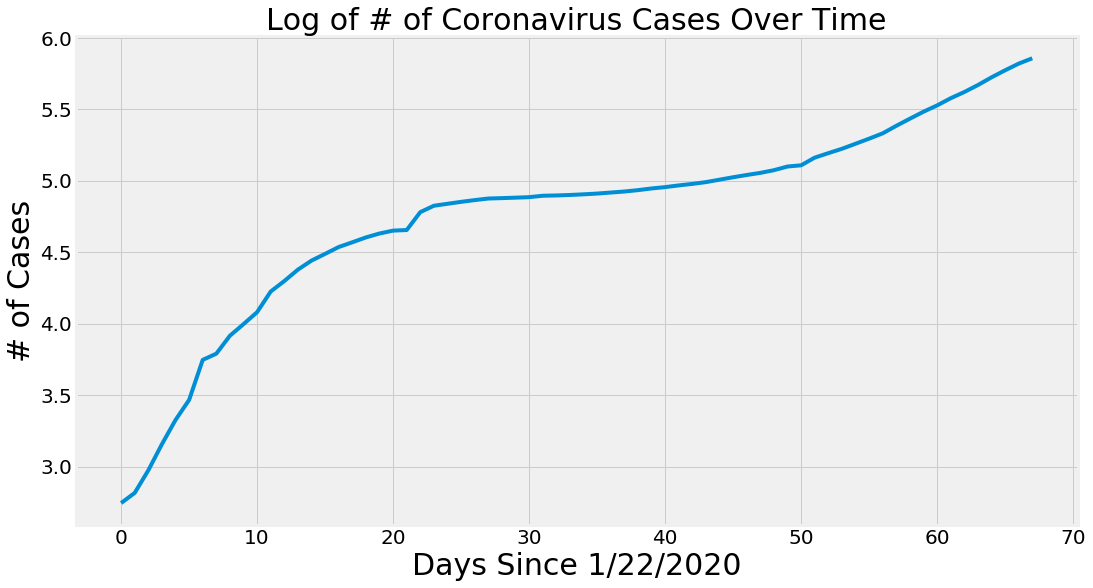

In [84]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

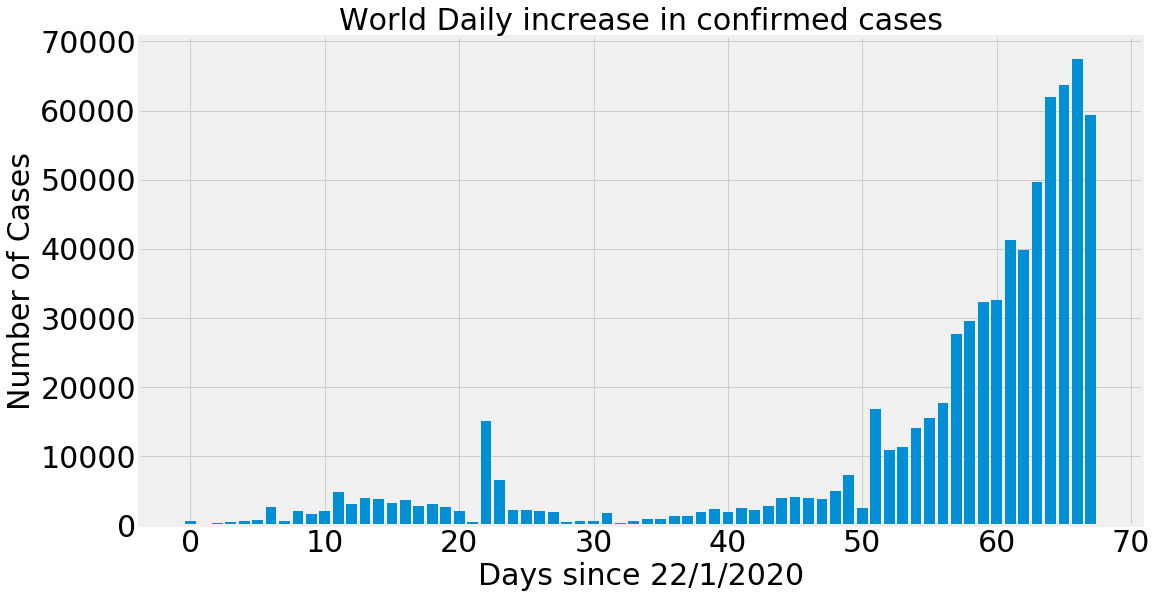

In [85]:
plt.figure(figsize=(16,9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title("World Daily increase in confirmed cases",size=30)
plt.xlabel('Days since 22/1/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.xticks(size=30)
plt.yticks(size=30)
plt.show()

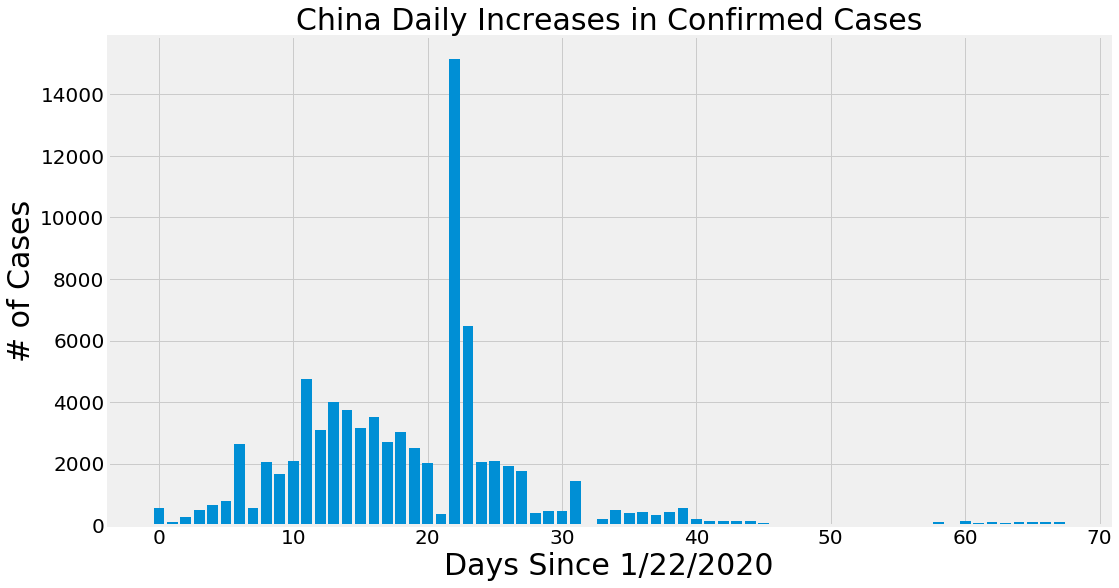

In [86]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, china_daily_increase)
plt.title('China Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

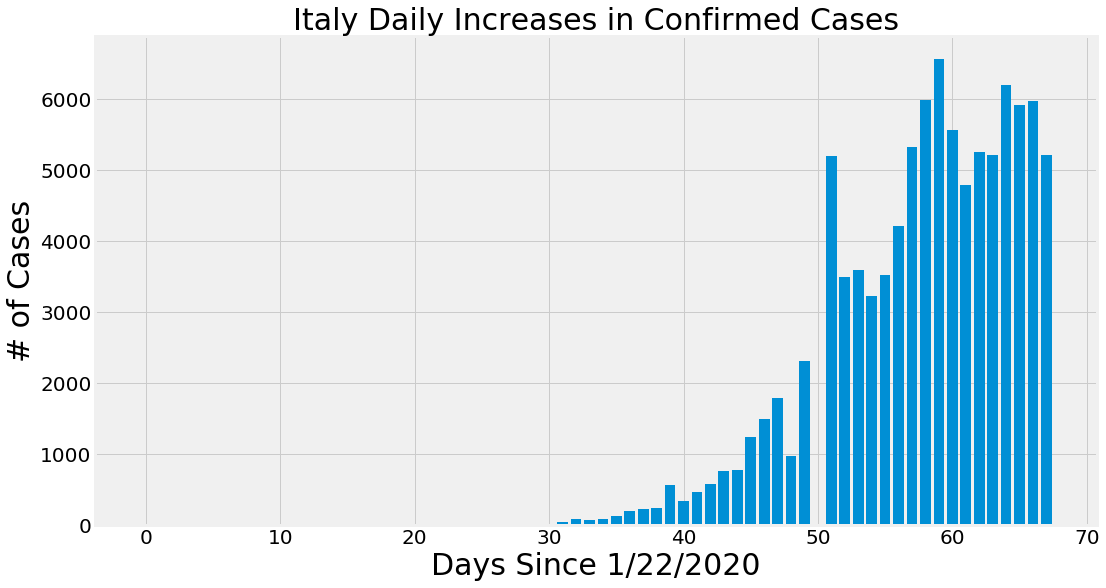

In [87]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, italy_daily_increase)
plt.title('Italy Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

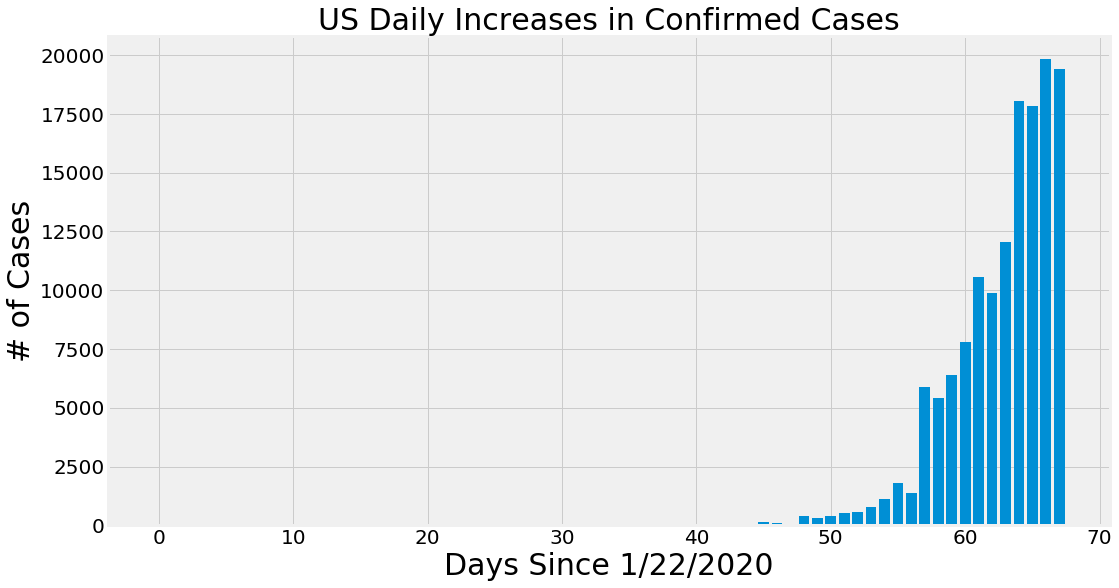

In [88]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, us_daily_increase)
plt.title('US Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

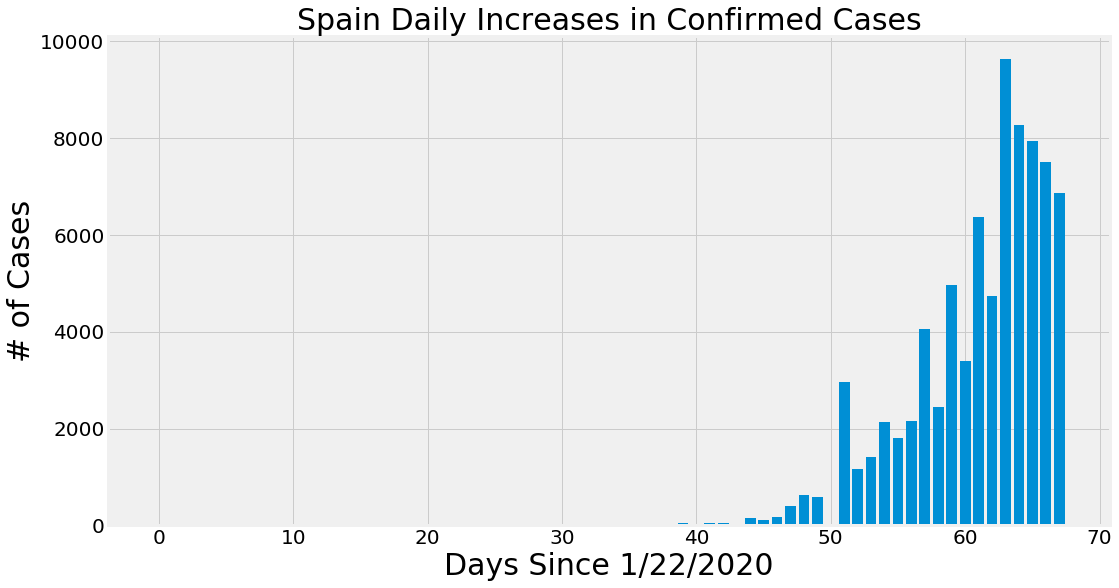

In [89]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, spain_daily_increase)
plt.title('Spain Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

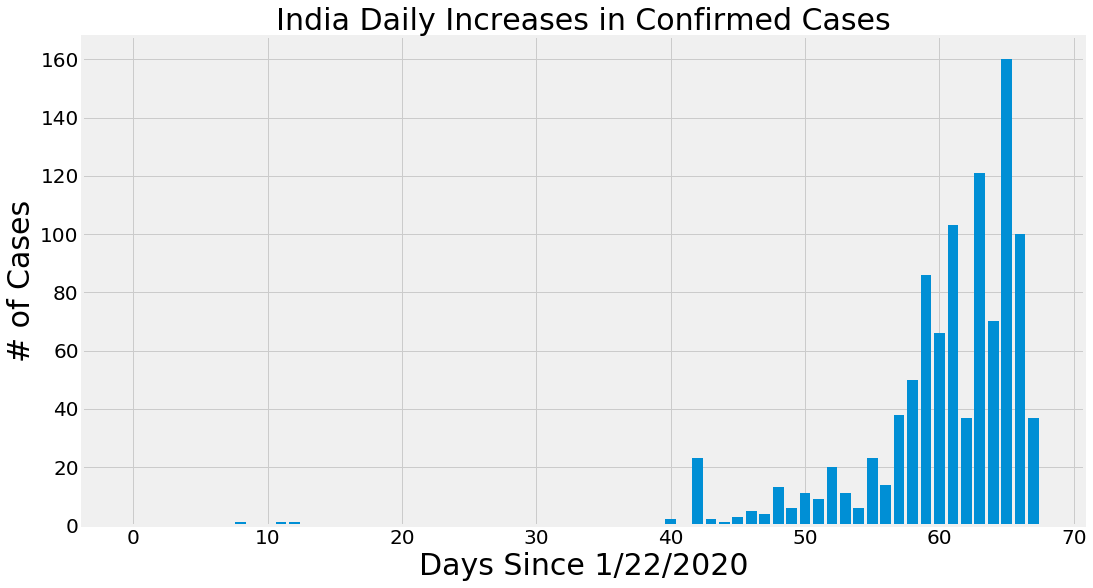

In [90]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, india_daily_increase)
plt.title('India Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

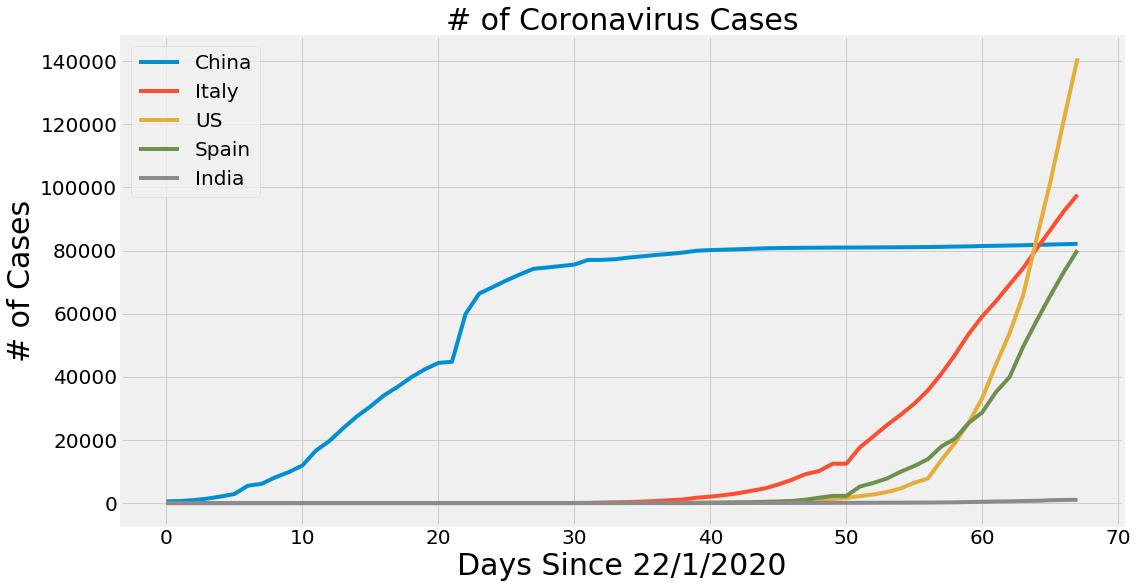

In [91]:
plt.figure(figsize=(16,9))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, spain_cases)
plt.plot(adjusted_dates, india_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain' , 'India'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

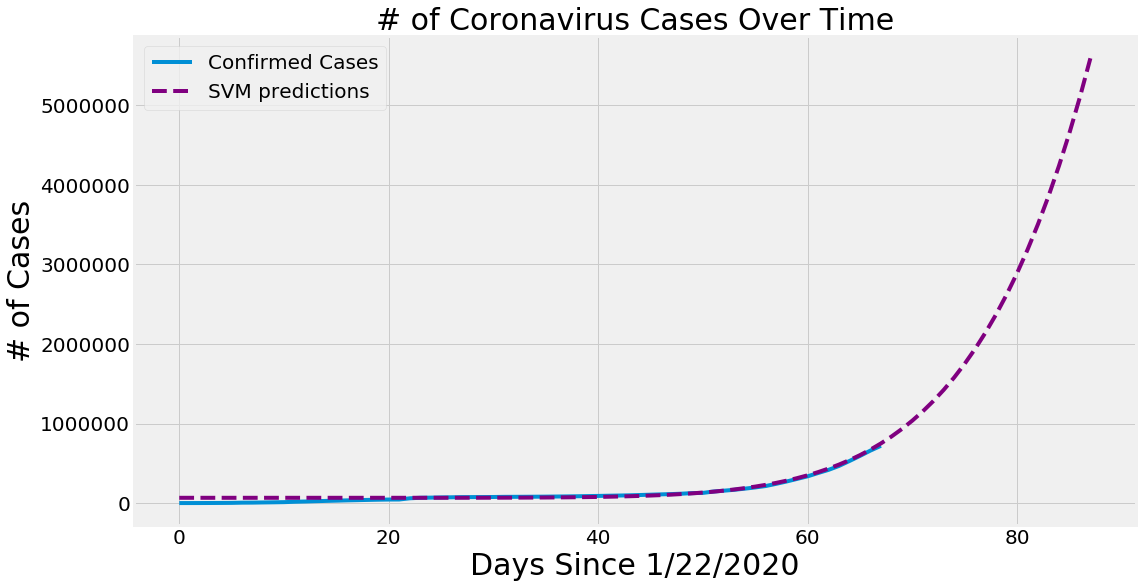

In [92]:
plt.figure(figsize=(16,9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forecast, svm_predict, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


In [93]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forecast_dates[-10:], np.round(svm_predict[-10:])))

SVM future predictions:


{('09/04/2020', 2373496.0),
 ('10/04/2020', 2620979.0),
 ('11/04/2020', 2891389.0),
 ('12/04/2020', 3186524.0),
 ('13/04/2020', 3508298.0),
 ('14/04/2020', 3858744.0),
 ('15/04/2020', 4240027.0),
 ('16/04/2020', 4654443.0),
 ('17/04/2020', 5104429.0),
 ('18/04/2020', 5592572.0)}

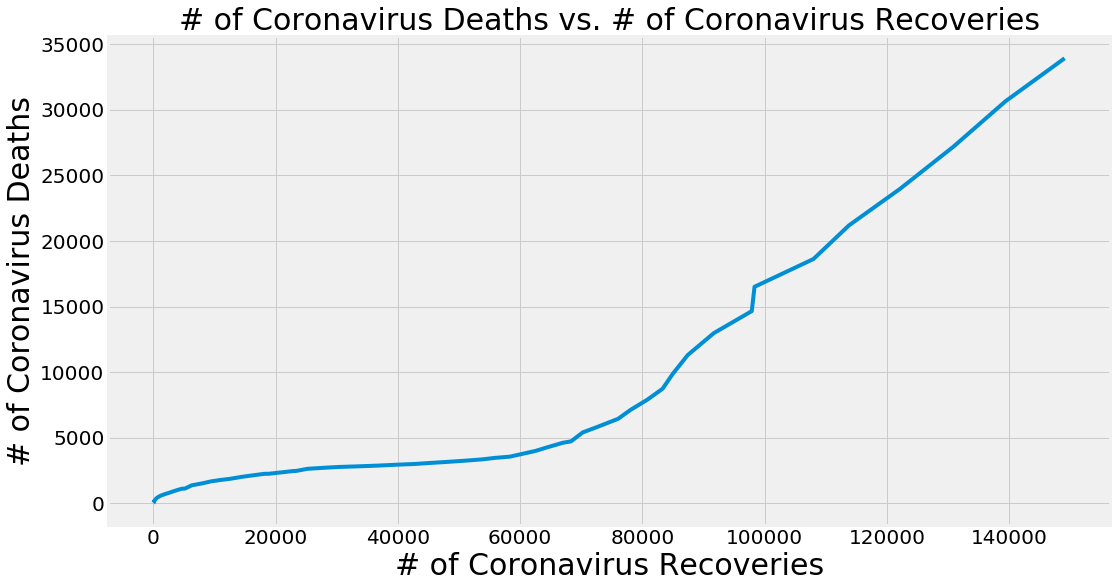

In [94]:
plt.figure(figsize=(16,9))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


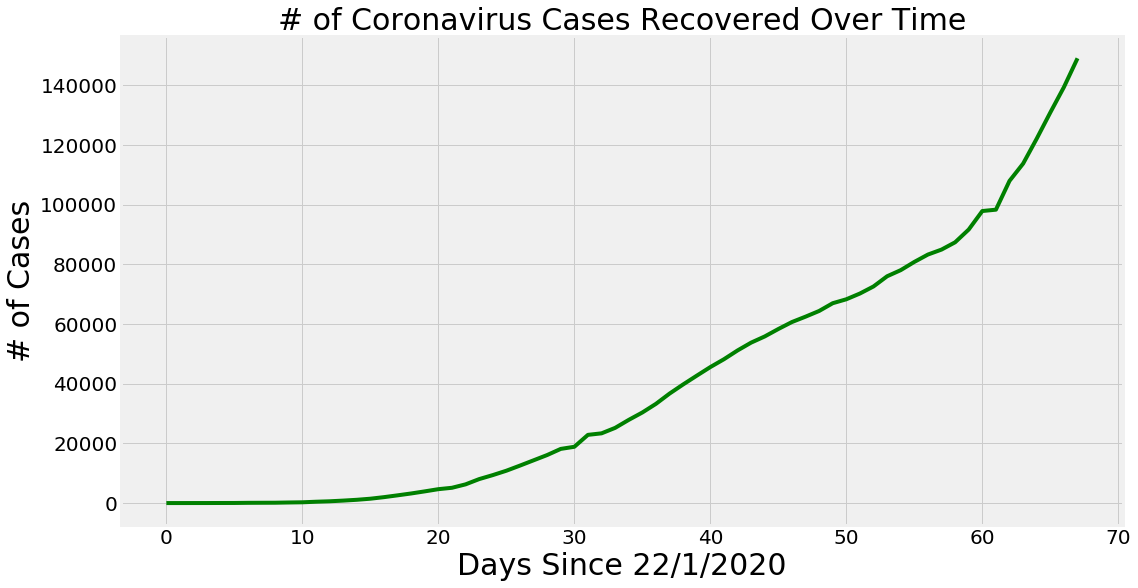

In [95]:
plt.figure(figsize=(16,9))
plt.plot(adjusted_dates, total_recovered, color='green')
plt.title('# of Coronavirus Cases Recovered Over Time', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


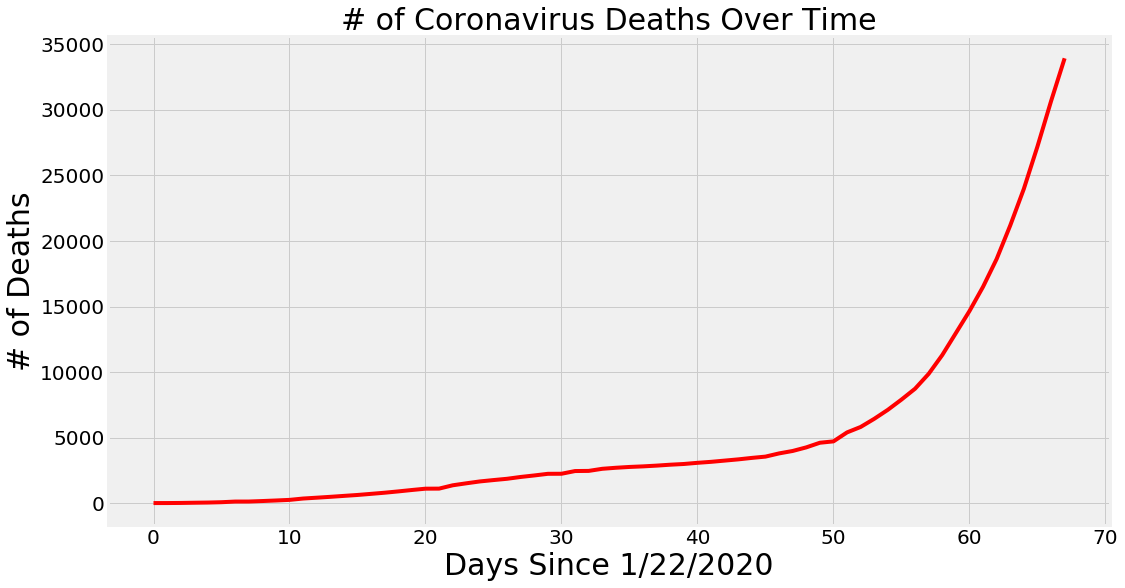

In [96]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

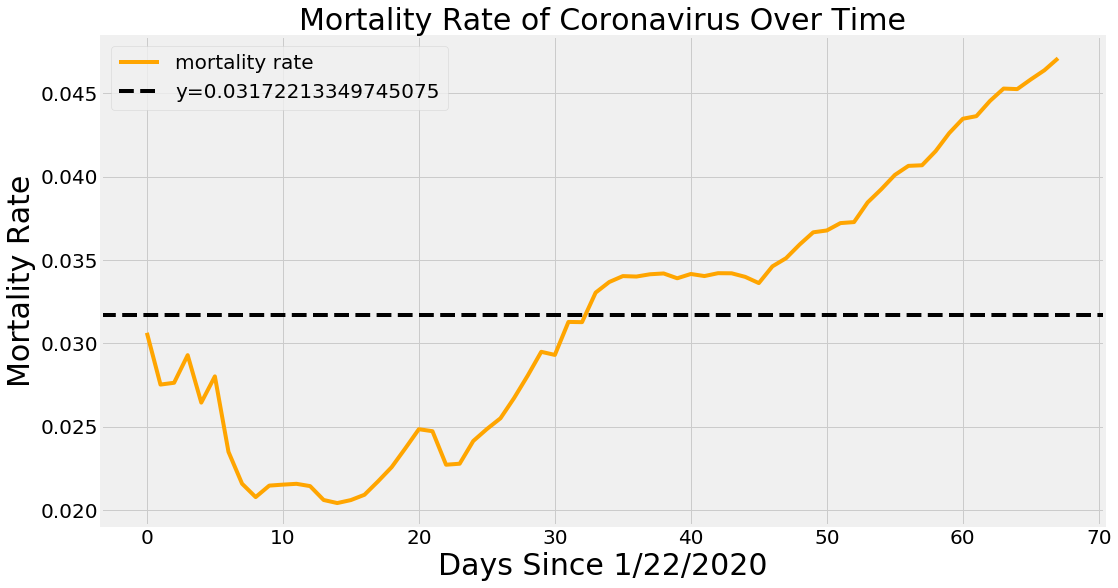

In [97]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [98]:
latest_confirmed = confirmcase_df[dates[-1]]
latest_deaths = deaths_df[dates[-1]]
latest_recoveries = recoveries_df[dates[-1]]

In [99]:
unique_countries =  list(confirmcase_df['Country/Region'].unique())

In [100]:
country_confirm_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmcase_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirm_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)

unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirm_cases), key = operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirm_cases[i] = latest_confirmed[confirmcase_df['Country/Region']==unique_countries[i]].sum()

In [101]:
# number of cases per country/region
print('Confirmed Cases by Countries/Regions:')
for i in range(len(unique_countries)):
   print(f'{unique_countries[i]}: {country_confirm_cases[i]} cases')

Confirmed Cases by Countries/Regions:
US: 140886 cases
Italy: 97689 cases
China: 82122 cases
Spain: 80110 cases
Germany: 62095 cases
France: 40708 cases
Iran: 38309 cases
United Kingdom: 19780 cases
Switzerland: 14829 cases
Netherlands: 10930 cases
Belgium: 10836 cases
Korea, South: 9583 cases
Turkey: 9217 cases
Austria: 8788 cases
Canada: 6280 cases
Portugal: 5962 cases
Norway: 4284 cases
Brazil: 4256 cases
Israel: 4247 cases
Australia: 3984 cases
Sweden: 3700 cases
Czechia: 2817 cases
Ireland: 2615 cases
Denmark: 2564 cases
Malaysia: 2470 cases
Chile: 2139 cases
Luxembourg: 1950 cases
Ecuador: 1924 cases
Japan: 1866 cases
Poland: 1862 cases
Romania: 1815 cases
Pakistan: 1597 cases
Russia: 1534 cases
Philippines: 1418 cases
Thailand: 1388 cases
Saudi Arabia: 1299 cases
Indonesia: 1285 cases
South Africa: 1280 cases
Finland: 1240 cases
Greece: 1156 cases
India: 1024 cases
Iceland: 1020 cases
Panama: 901 cases
Dominican Republic: 859 cases
Peru: 852 cases
Mexico: 848 cases
Singapore: 84

In [102]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirm_cases[10:])

for i in range(len(country_confirm_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirm_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

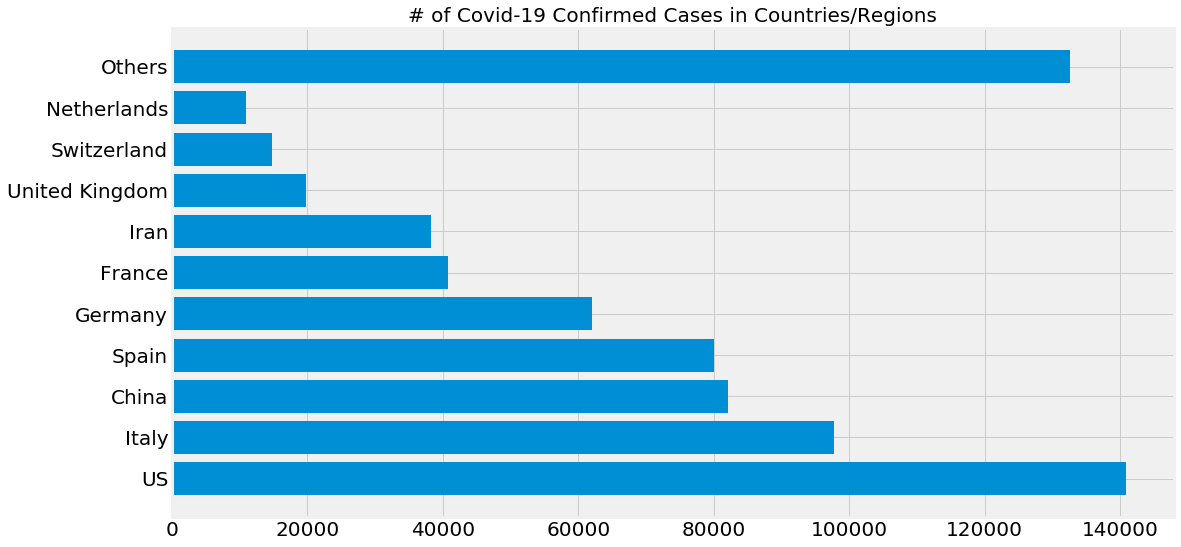

In [103]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

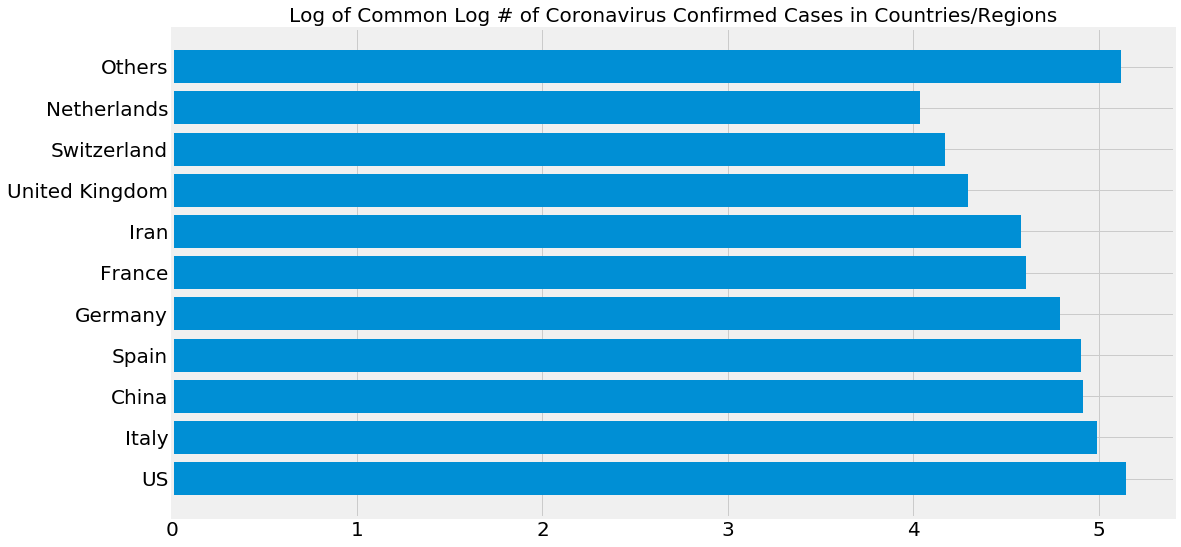

In [104]:
# lets look at it in a logarithmic scale 
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, log_country_confirmed_cases)
plt.title('Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

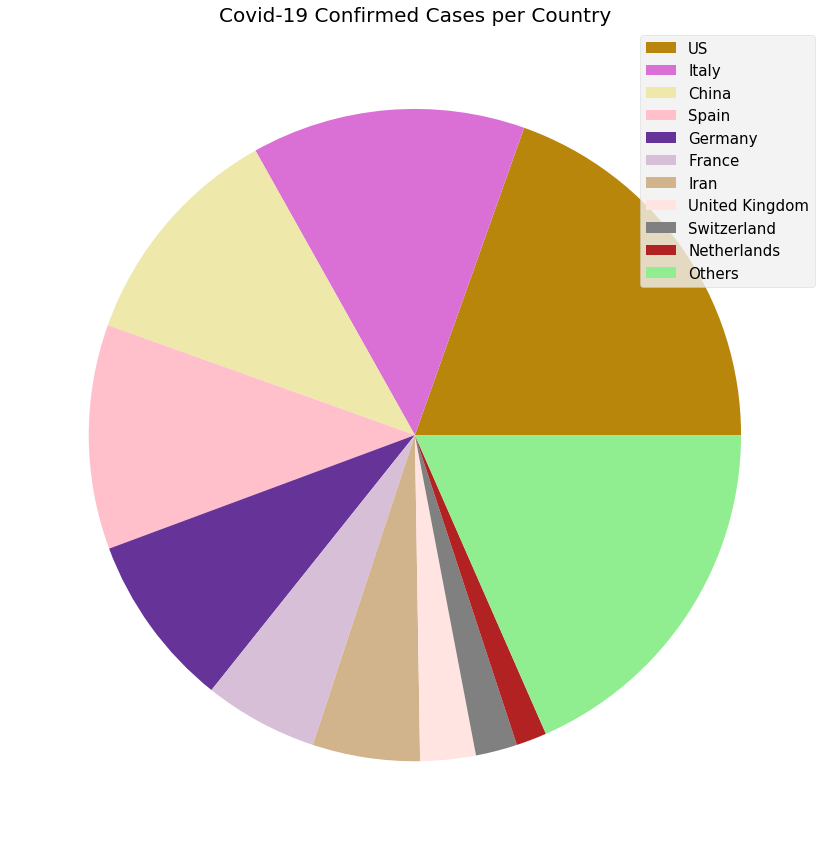

In [105]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases per Country', size=20)
plt.pie(visual_confirmed_cases, colors=c)
plt.legend(visual_unique_countries, loc='best', fontsize=15)
plt.show()